In [1]:
import numpy as np
import shutil
import matplotlib
import matplotlib.pyplot as plt
from astropy import table
from astropy.io import ascii
import cmasher as cmr
import dynamite as dyn
from plotbin import display_pixels

In [2]:
# Get an estimate for the weights from losvd optimization (config files MUST have the same parsets)
# fname = 'user_test_config_ml.yaml'
# c = dyn.config_reader.Configuration(fname        ,                #   |
#                                     reset_logging=True,           #   |
#                                     user_logfile='test_nnls',     #   v
#                                     reset_existing_output=True)   # 'False' saves time, use only if orblibs have been created with the current orblib_new_mirror
# _ = dyn.model_iterator.ModelIterator(config=c)
# best_model_idx = c.all_models.get_best_n_models_idx(n=1)[0]
# model = c.all_models.get_model_from_row(best_model_idx)
# parset = model.parset
# print(f'{parset=}')
# orblib = model.get_orblib()
# _ = model.get_weights(orblib)
# weights = model.weights
# print(f'{weights=}')
# orblib.read_losvd_histograms()
# print(f'{len(orblib.losvd_histograms)=}\t{len(orblib.intrinsic_masses)=}\t{len(orblib.projected_masses)=}\t{orblib.n_orbs=}')
# shutil.copyfile(model.directory + 'orbit_weights.ecsv', 'weights.ecsv')

In [3]:
# Get losvd and proper motion histograms for same model (config files MUST have the same parsets)
fname = 'user_test_config_ml_with_pm.yaml'
c = dyn.config_reader.Configuration(fname,                        #   |
                                    reset_logging=True,           #   |
                                    user_logfile='test_nnls',     #   v
                                    reset_existing_output=False)   # 'False' saves time, use only if orblibs have been created with the current orblib_new_mirror
stars = c.system.get_unique_triaxial_visible_component()
parset = c.parspace.get_parset()
parset['ml'] = 1
model = dyn.model.Model(config=c, parset=parset)  # parset taken from above
model.setup_directories()
orblib = model.get_orblib()
print(f'{orblib.parset=}')
orblib.read_losvd_histograms()
print(f'{len(orblib.losvd_histograms)=}\t{len(orblib.intrinsic_masses)=}\t{len(orblib.projected_masses)=}\t{orblib.n_orbs=}')

[INFO] 14:31:35 - dynamite.config_reader.Configuration - Config file user_test_config_ml_with_pm.yaml read.
[INFO] 14:31:35 - dynamite.config_reader.Configuration - io_settings...
[INFO] 14:31:35 - dynamite.config_reader.Configuration - Output directory tree: NGC6278_output/.
[INFO] 14:31:35 - dynamite.config_reader.Configuration - system_attributes...
[INFO] 14:31:35 - dynamite.config_reader.Configuration - model_components...
[INFO] 14:31:35 - dynamite.physical_system.Component - bh: DYNAMITE will currently ignore the mandatory attribute contributes_to_potential.
[INFO] 14:31:35 - dynamite.physical_system.Component - dh: DYNAMITE will currently ignore the mandatory attribute contributes_to_potential.
[INFO] 14:31:35 - dynamite.physical_system.Component - stars: DYNAMITE will currently ignore the mandatory attribute contributes_to_potential.
[INFO] 14:31:35 - dynamite.config_reader.Configuration - system_parameters...
[INFO] 14:31:35 - dynamite.config_reader.Configuration - orblib_set

orblib.parset=<Row index=0>
  m-bh     a-bh    c-dh    f-dh  q-stars p-stars u-stars    ml  
float64  float64 float64 float64 float64 float64 float64 float64
-------- ------- ------- ------- ------- ------- ------- -------
100000.0   0.001  1000.0    10.0    0.54    0.99  0.9999     1.0
len(orblib.losvd_histograms)=2	len(orblib.intrinsic_masses)=360	len(orblib.projected_masses)=2	orblib.n_orbs=360


In [4]:
for h in orblib.losvd_histograms:
    print(f'{h}: {h.y.shape=}\n')
    mean = h.get_mean()
    sigma = h.get_sigma()
    if type(h.xedg)==tuple:
        print(f'{[x.shape for x in h.xedg]=}, {[x.shape for x in h.x]=}')
        print(f'{[x.shape for x in mean]=}\n{[x.shape for x in sigma]=}')
    else:
        print(f'{h.xedg.shape=}, {h.x.shape=}')
        print(f'{mean.shape=}\n{sigma.shape=}')
#    print(f'{h.get_normalisation().shape=}')
#    print(f'{np.sum(h.y)=}')
#    h.normalise()
#    print(f'{np.sum(h.y)=}')

<dynamite.kinematics.Histogram object at 0x123671110>: h.y.shape=(360, 203, 152)

h.xedg.shape=(204,), h.x.shape=(203,)
mean.shape=(360, 152)
sigma.shape=(360, 152)
<dynamite.kinematics.Histogram2D object at 0x124971d90>: h.y.shape=(360, 15, 11, 152)

[x.shape for x in h.xedg]=[(16,), (12,)], [x.shape for x in h.x]=[(15,), (11,)]
[x.shape for x in mean]=[(360, 152), (360, 152)]
[x.shape for x in sigma]=[(360, 152), (360, 152)]


vx_range=[-1269.2500488281134, 1269.2500488281134], vy_range=[-454.54545454545456, 454.5454545454545]


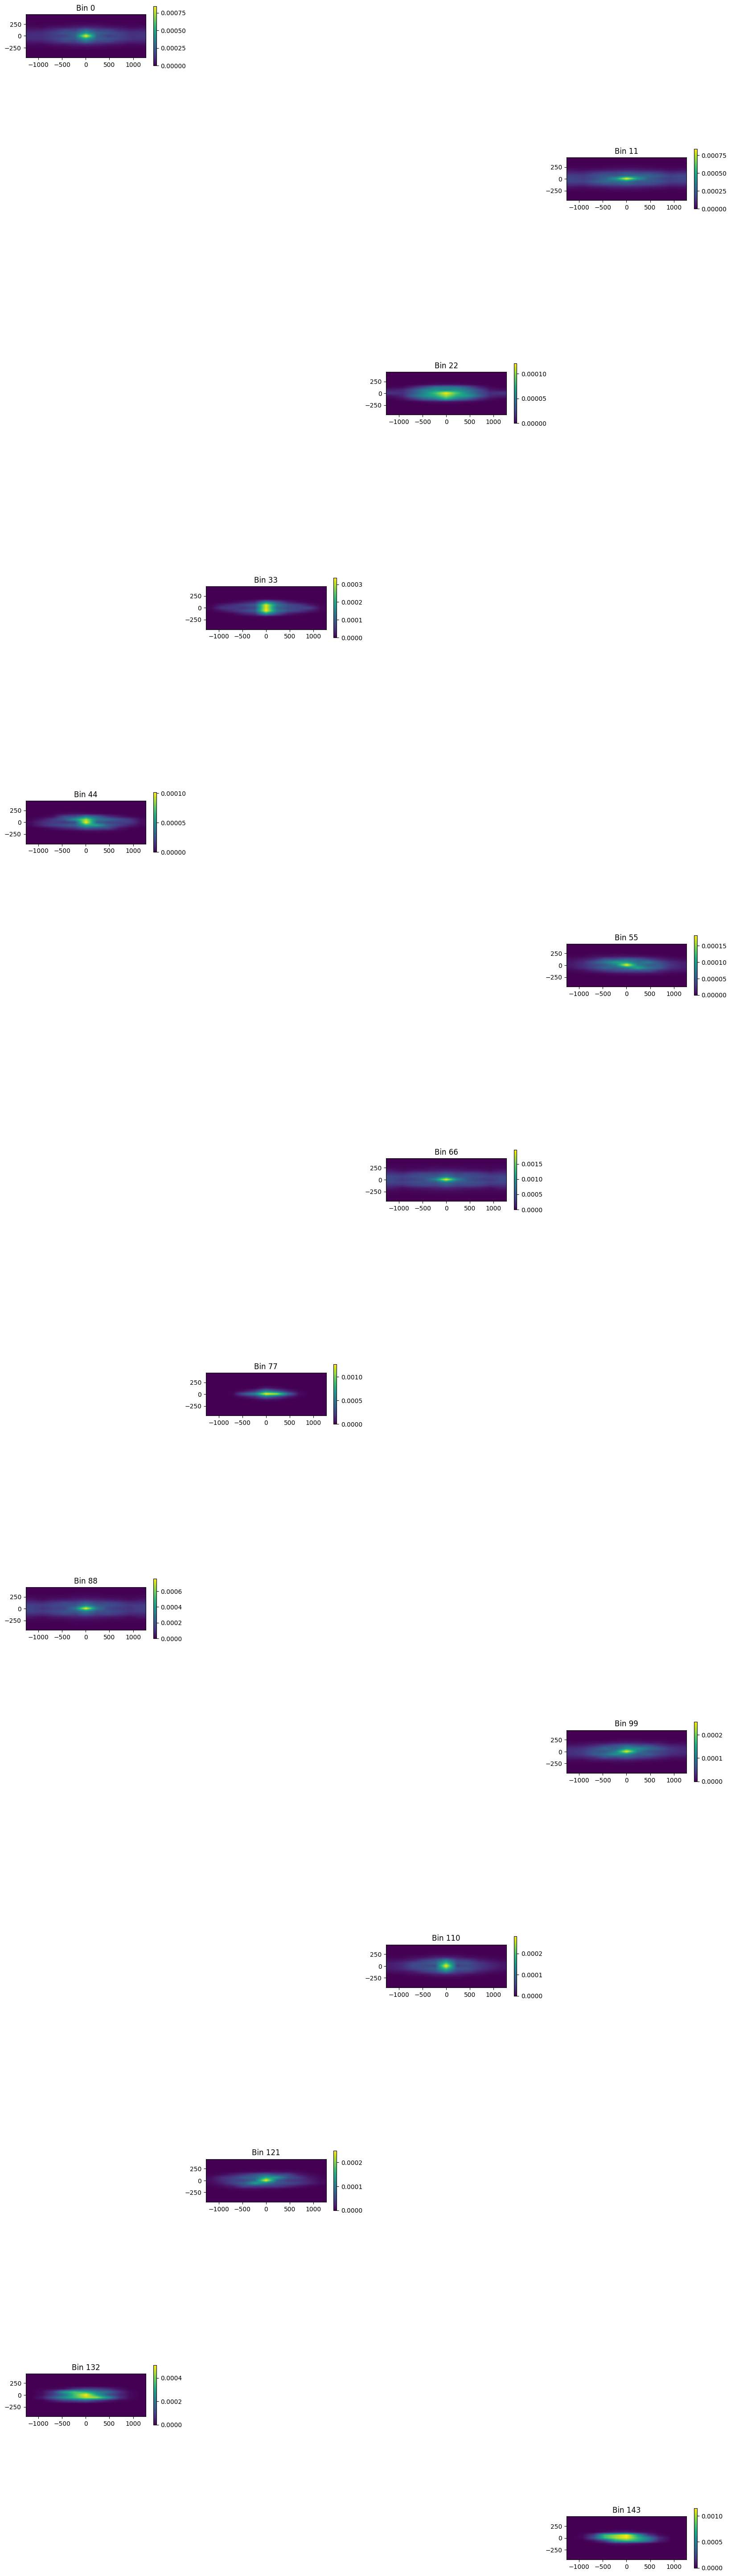

In [5]:
# plot pm histograms for all spatial bins
hist2d = orblib.losvd_histograms[1]
n_orbits = hist2d.y.shape[0]
n_bins = hist2d.y.shape[-1]

# orb_weights = np.ones(n_orbits)
orb_weights = ascii.read('weights.ecsv')['weights']

vx_range = [hist2d.x[0].min(), hist2d.x[0].max()]
vy_range = [hist2d.x[1].min(), hist2d.x[1].max()]
ratio = (vy_range[1]-vy_range[0]) / (vx_range[1]-vx_range[0])
print(f'{vx_range=}, {vy_range=}')

fig = plt.figure(figsize=(20, 20 * (n_bins // 4 // 4 + 2) * ratio))
for bin_idx in range(0, n_bins, 11):
#    data = np.einsum('ijkl,i', hist2d.y, orb_weights)[:,:,bin_idx]
    data = np.dot(hist2d.y.T, orb_weights).T[:,:,bin_idx]
    ax = plt.subplot(n_bins // 4 + (1 if n_bins % 4 > 0 else 0), 4, bin_idx + 1)
    im = ax.imshow(data, aspect='equal', interpolation='bilinear', #cmap=cm.RdYlGn,
                   origin='lower', extent=vx_range + vy_range,
                   vmax=data.max(), vmin=0)
    fig.colorbar(im, ax=ax, shrink=1)
    ax.set_title(f'Bin {bin_idx}')

plt.show()

vx_range=[-1269.2500488281134, 1269.2500488281134], vy_range=[-454.54545454545456, 454.5454545454545]


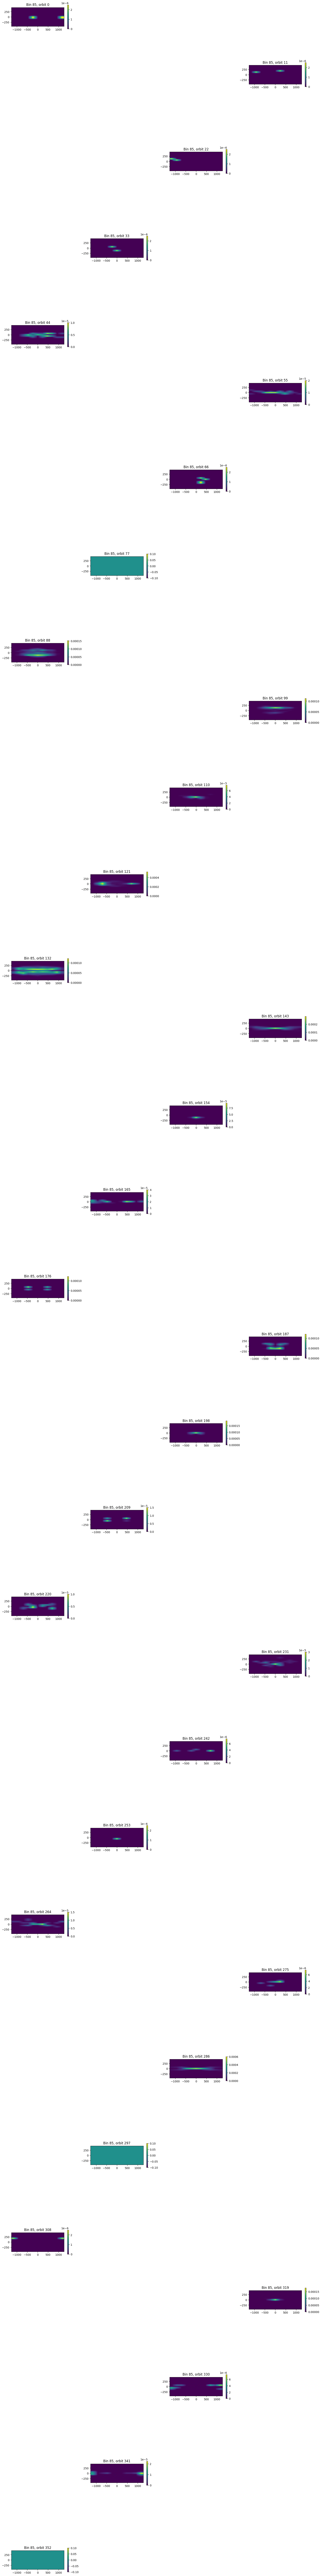

In [6]:
# plot pm histograms for specific bin
hist2d = orblib.losvd_histograms[1]
n_orbits = hist2d.y.shape[0]

bin_idx = 85

hist2d = orblib.losvd_histograms[1]
vx_range = [hist2d.x[0].min(), hist2d.x[0].max()]
vy_range = [hist2d.x[1].min(), hist2d.x[1].max()]
ratio = (vy_range[1]-vy_range[0]) / (vx_range[1]-vx_range[0])
print(f'{vx_range=}, {vy_range=}')

fig = plt.figure(figsize=(20, 20 * (n_orbits // 4 // 4 + 2) * ratio))
for orb_idx in range(0, n_orbits, 11):
    data = hist2d.y[orb_idx,:,:,bin_idx]
    ax = plt.subplot(n_orbits // 4 + (1 if n_orbits % 4 > 0 else 0), 4, orb_idx + 1)
    im = ax.imshow(data, aspect='equal', interpolation='bilinear', #cmap=cm.RdYlGn,
                   origin='lower', extent=vx_range + vy_range,
                   vmax=data.max(), vmin=0)
    fig.colorbar(im, ax=ax)
    ax.set_title(f'Bin {bin_idx}, orbit {orb_idx}')

plt.show()

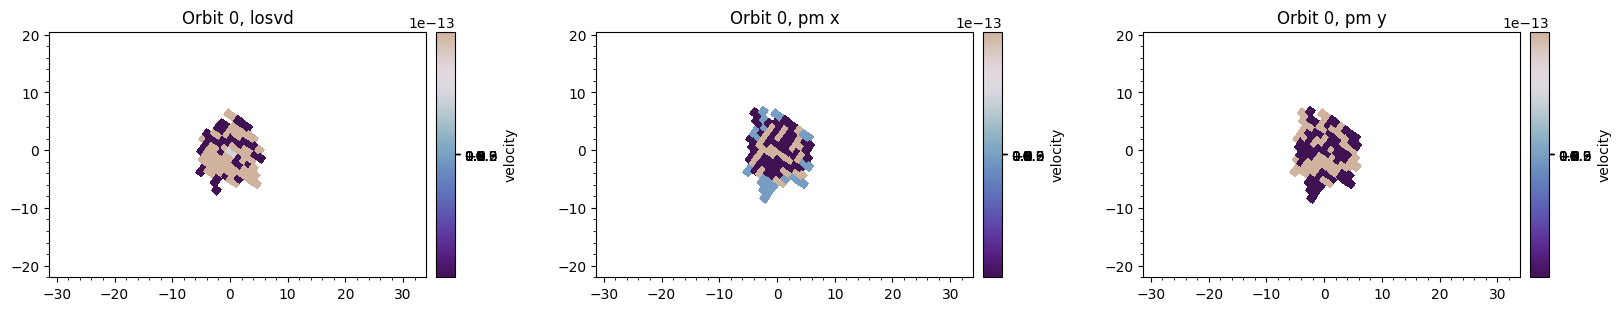

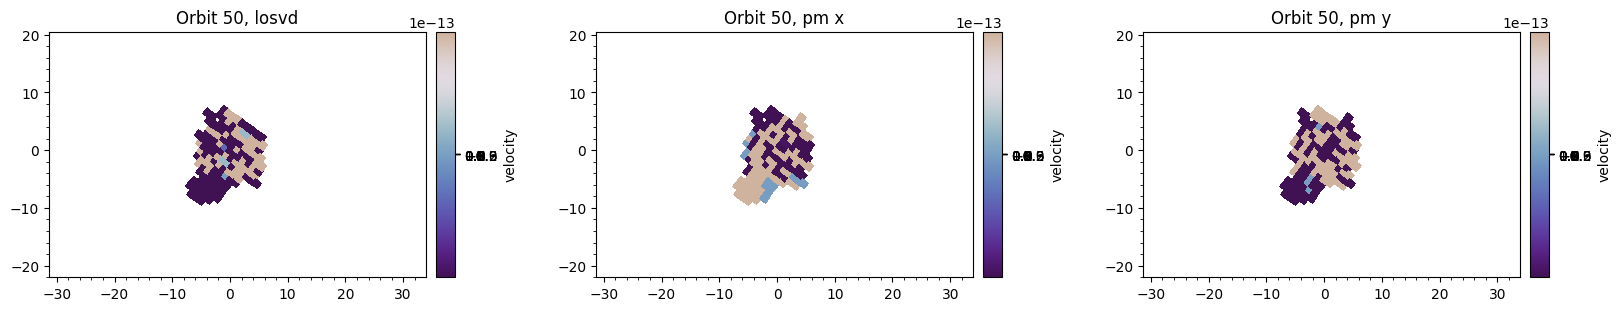

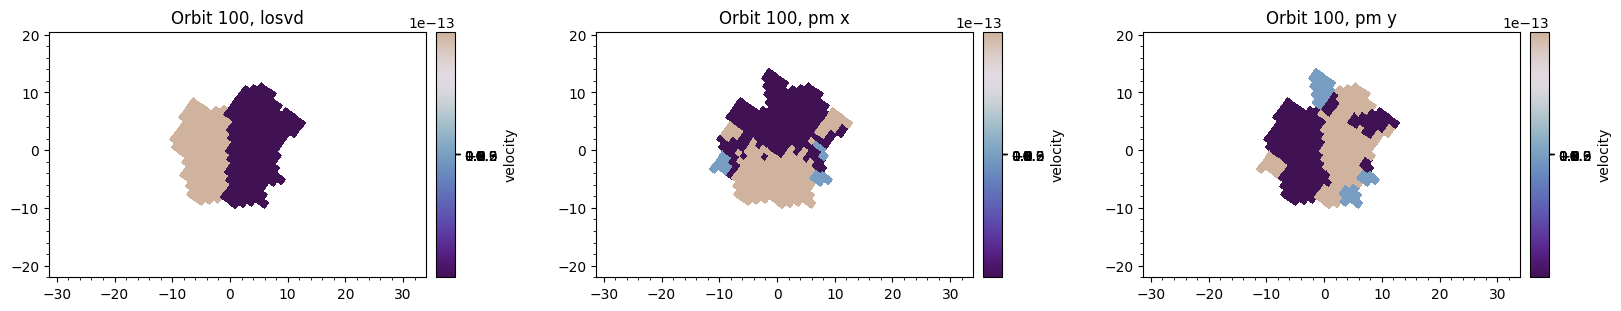

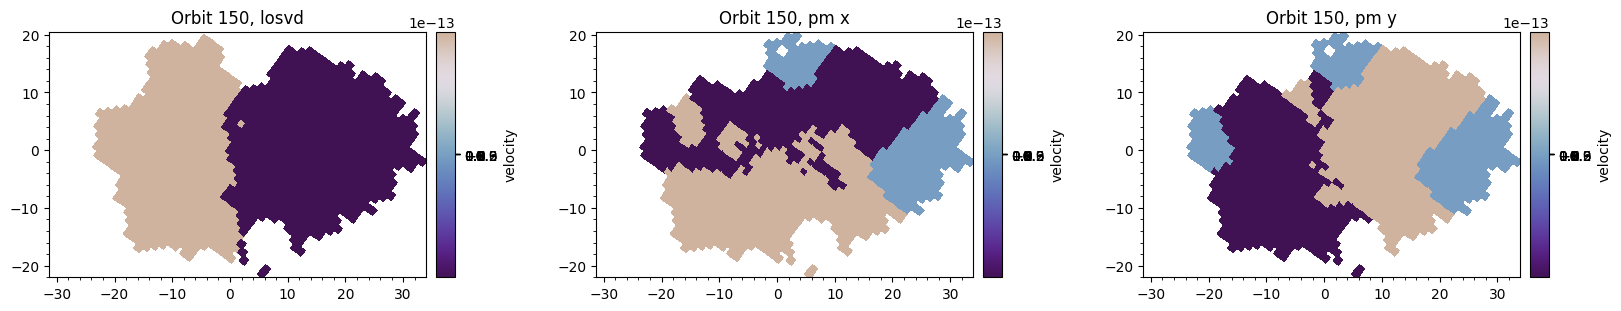

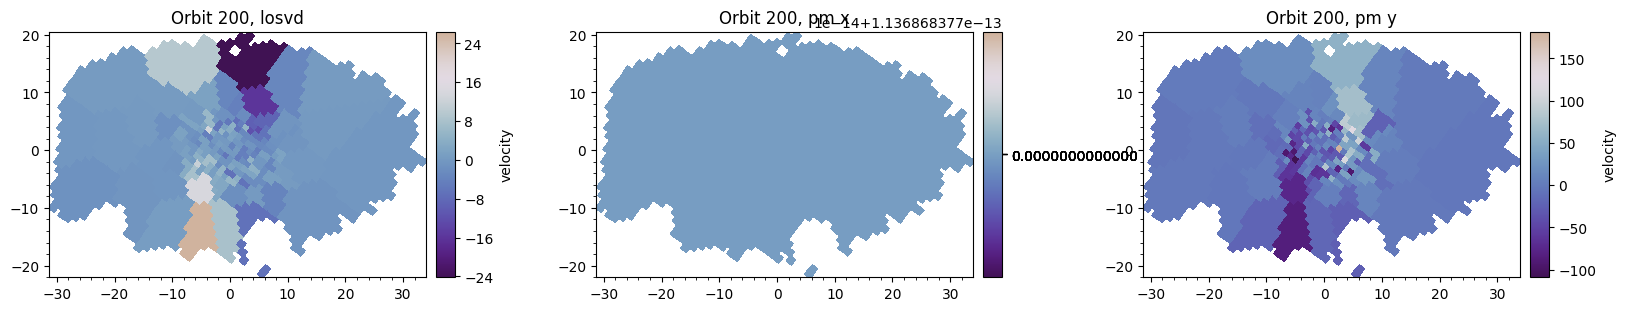

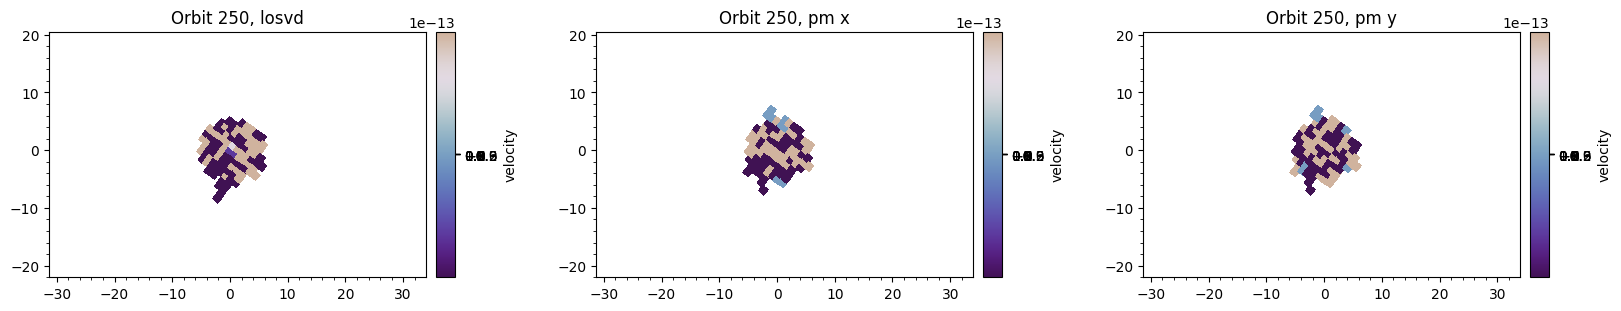

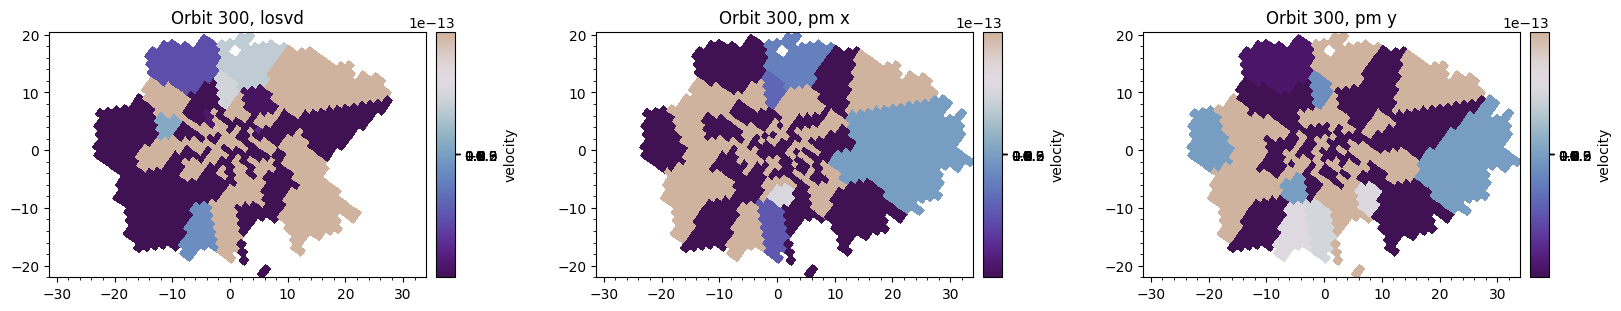

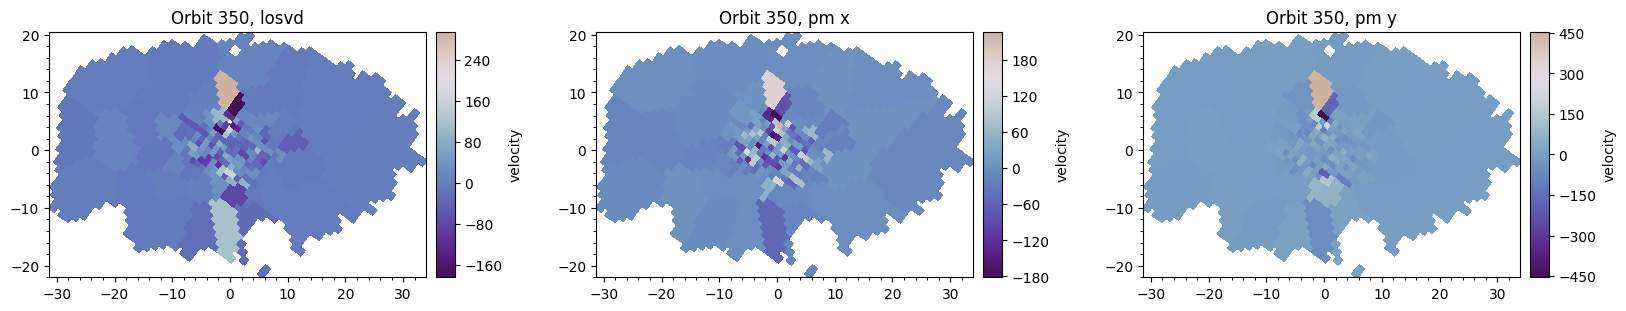

In [7]:
# plot the losvd and pm histograms' mean values
# mostly from plotter.py
orb_skip = 50
for i, orb_idx in enumerate(range(0, orblib.n_orbs, orb_skip)):

    def create_plot(dp_args, data):
        # get aperture and bin data
        x = dp_args['x']
        y = dp_args['y']
        dx = dp_args['dx']
        grid = dp_args['idx_bin_to_pix']
        angle_deg = dp_args['angle']
        # Only select the pixels that have a bin associated with them.
        s = np.ravel(np.where((grid >= 0)))
    
        #fhist, _ = np.histogram(grid[s], bins=len(data))
        #data = data / fhist
        # plot settings
        #data_min = min(data[grid[s]] / max(data))
        #data_max = max(data[grid[s]] / max(data))
        # The galaxy has NOT already rotated with PA to align major axis with x
        map1 = cmr.get_sub_cmap('twilight_shifted', 0.05, 0.6)
        kw_display_pixels1 = dict(pixelsize=dx,
                                  angle=angle_deg,
                                  colorbar=True,
                                  nticks=7,
                                  # cmap='sauron')
                                  cmap=map1)
        # PLOT THE DATA
        #plt.figure()
        #c_c = data[grid[s]] / max(data)
        c_c = data[grid[s]]
        display_pixels.display_pixels(x, y, c_c,
                                      vmin=min(data[grid[s]]), vmax=max(data[grid[s]]),
                                      label='velocity',
                                      **kw_display_pixels1)
        #plt.gca().set_title(title)
        #plt.show()

    fig = plt.figure(figsize=(20, 30))

    n_rows, n_cols = orblib.n_orbs // orb_skip + 1, 3

    ax = plt.subplot(n_rows, n_cols, n_cols * i + 1)
    if len(orblib.losvd_histograms) > 1:  # assuming that 1d histograms are first, if existing
        ax.set_title(f'Orbit {orb_idx}, losvd')
        mean = orblib.losvd_histograms[0].get_mean()[orb_idx]
        create_plot(stars.kinematic_data[0].dp_args, mean)

    idx = 1 if len(orblib.losvd_histograms) > 1 else 0  # assuming that 1d histograms are first, if existing

    ax = plt.subplot(n_rows, n_cols, n_cols * i + 2)
    ax.set_title(f'Orbit {orb_idx}, pm x')
    mean = orblib.losvd_histograms[idx].get_mean()[0][orb_idx]
    create_plot(stars.kinematic_data[idx].dp_args, mean)

    ax = plt.subplot(n_rows, n_cols, n_cols * i + 3)
    ax.set_title(f'Orbit {orb_idx}, pm y')
    mean = orblib.losvd_histograms[idx].get_mean()[1][orb_idx]
    create_plot(stars.kinematic_data[idx].dp_args, mean)

    #ax = plt.subplot(n_rows, n_cols, n_cols, n_cols * i + 4)
    #ax.set_title(f'Orbit {orb_idx}, pm vector field')


In [8]:
p = dyn.plotter.Plotter(c)

In [9]:
orb_idx = 66
sp_bin_idx = 85

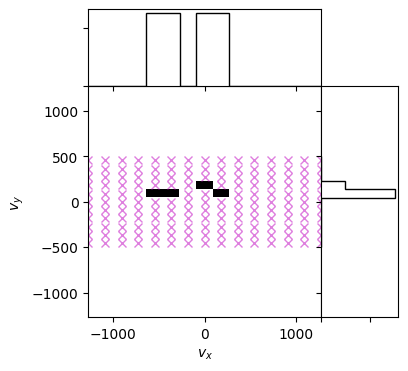

In [10]:
_ = p.hist2d_plot(hist2d, orb_idx=orb_idx, sp_bin_idx=sp_bin_idx, show_1d=True, empty_bins=True)

In [11]:
for x_idx, x in enumerate(hist2d.x[0]):
    for y_idx, y in enumerate(hist2d.x[1]):
        if hist2d.y[orb_idx,x_idx,y_idx,sp_bin_idx] != 0:
            print(f'{x} {y} {hist2d.y[orb_idx,x_idx,y_idx,sp_bin_idx]}')
print(np.where(hist2d.y[orb_idx,:,:,sp_bin_idx]!=0))

-543.96430664062 90.90909090909093 2.5e-06
-362.6428710937466 90.90909090909093 2.5e-06
1.1368683772161603e-13 181.8181818181818 2.5e-06
181.32143554687343 90.90909090909093 2.5e-06
(array([4, 5, 7, 8]), array([6, 6, 7, 6]))


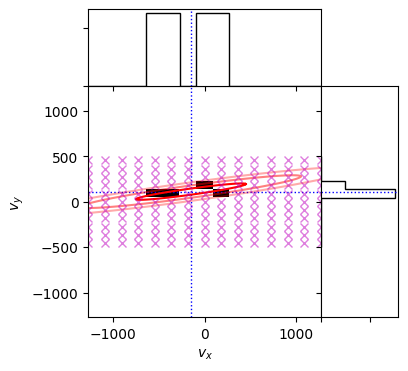

In [12]:
## mean velocity
mean_vx = -150
mean_vy = 112

## velocity dispersion
sx  = 600
sy  = 90

## cross moment
sxy = 50000


mu  = [mean_vx,mean_vy]
cov = [[sx**2,sxy],[sxy,sy**2]]

_ = p.hist2d_plot(hist2d,
                  orb_idx=orb_idx,
                  sp_bin_idx=sp_bin_idx,
                  show_1d=True,
                  draw_vel_ellips=True,
                  moments=[mu[0],mu[1],cov[0][0],cov[1][1],cov[0][1]],
                  sigmas=[1,2,3],
                  empty_bins=True)